# Problem Statement for Schuster's Payment Prediction Model
Background: Schuster is a multinational retail company specializing in sports goods and accessories. It engages in frequent transactions with numerous vendors, often on credit. However, not all vendors adhere to their credit terms, leading to late payments. Schuster has employees dedicated to managing these payments, which unfortunately results in time and financial inefficiencies.

Objective: Schuster aims to understand its vendors' payment behaviors and develop a predictive model to estimate the likelihood of late payments for open invoices. This information will help prioritize collector activities, improve payment compliance, and maintain healthy business relationships.

Data Description:

Received Payments Data: Historical transactions with detailed payment records, including payment terms, dates, amounts, and customer details.

Open Invoices Data: Current outstanding invoices lacking complete payment details as these transactions are still open.
Tasks:

Data Preparation:
Clean and preprocess both datasets.
Derive a binary target variable indicating whether payments were made on time or late based on historical data.
Feature Engineering:
Convert textual payment terms into numerical data.
Generate customer-level metrics like average payment time and variance using past data.
Model Development:
Identify predictive features for late payments.
Build and evaluate several classification models to forecast late payments.
Customer Segmentation:
Classify customers based on their payment behaviors using clustering techniques.
Deployment and Results:
Deploy the model to predict late payments on open invoices.
Summarize model findings and customer segments visually.
Recommend strategies for managing high-risk customers.
Expected Outcomes:

A robust predictive model that accurately forecasts payment delays.
Actionable insights that enable preemptive engagement with vendors likely to delay payments, thereby optimizing resource allocation and enhancing cash flow management.cing cash flow management.

# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Configure matplotlib to show figures inline in the notebook
# %matplotlib inline

# Ignore warnings
warnings.filterwarnings("ignore")


# Load datasets

In [4]:
received_payments_data = pd.read_csv('Received_Payments_Data.csv')

In [5]:
data = received_payments_data.copy() # Create a copy of the original dataset

In [6]:
data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [7]:
# Summary
data.info(),100*data.isnull().sum()/len(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93937 non-null  object 
 1   CUSTOMER_NAME          93937 non-null  object 
 2   CUSTOMER_NUMBER        93937 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93937 non-null  object 
 5   CLASS                  93937 non-null  object 
 6   CURRENCY_CODE          93937 non-null  object 
 7   Local Amount           93937 non-null  float64
 8   USD Amount             93937 non-null  float64
 9   INVOICE_ALLOCATED      93937 non-null  object 
 10  INVOICE_CREATION_DATE  93937 non-null  object 
 11  DUE_DATE               93937 non-null  object 
 12  PAYMENT_TERM           93937 non-null  object 
 13  INVOICE_CLASS          93937 non-null  object 
 14  INVOICE_CURRENCY_CODE  93937 non-null  object 
 15  IN

(None,
 RECEIPT_METHOD           0.000000
 CUSTOMER_NAME            0.000000
 CUSTOMER_NUMBER          0.000000
 RECEIPT_DOC_NO           0.030872
 RECEIPT_DATE             0.000000
 CLASS                    0.000000
 CURRENCY_CODE            0.000000
 Local Amount             0.000000
 USD Amount               0.000000
 INVOICE_ALLOCATED        0.000000
 INVOICE_CREATION_DATE    0.000000
 DUE_DATE                 0.000000
 PAYMENT_TERM             0.000000
 INVOICE_CLASS            0.000000
 INVOICE_CURRENCY_CODE    0.000000
 INVOICE_TYPE             0.000000
 dtype: float64)

# The dataset contains 93,937 entries and 16 columns, as follows:

### RECEIPT_METHOD: Method of payment receipt.
### CUSTOMER_NAME: Name of the customer.
### CUSTOMER_NUMBER:  Numeric identifier for the customer.
### RECEIPT_DOC_NO: Receipt document number.
### RECEIPT_DATE: Date when payment was received.
### CLASS: General classification of the record.
### CURRENCY_CODE: Code of the currency used.
### Local Amount: The amount in local currency.
### USD Amount: The amount converted to USD.
### INVOICE_ALLOCATED: Invoice number allocated to the payment.
### INVOICE_CREATION_DATE: Date when the invoice was created.
### DUE_DATE: Due date for the invoice payment.
### PAYMENT_TERM: Terms of payment (in text format).
### INVOICE_CLASS: Classification of the invoice.
### INVOICE_CURRENCY_CODE: Currency code of the invoice.
### INVOICE_TYPE: Type of invoice.

In [532]:
data = data.dropna() # dropping null value given that they are very small no. of rows (0.031%)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93908 entries, 0 to 93907
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93908 non-null  object 
 1   CUSTOMER_NAME          93908 non-null  object 
 2   CUSTOMER_NUMBER        93908 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93908 non-null  object 
 5   CLASS                  93908 non-null  object 
 6   CURRENCY_CODE          93908 non-null  object 
 7   Local Amount           93908 non-null  float64
 8   USD Amount             93908 non-null  float64
 9   INVOICE_ALLOCATED      93908 non-null  object 
 10  INVOICE_CREATION_DATE  93908 non-null  object 
 11  DUE_DATE               93908 non-null  object 
 12  PAYMENT_TERM           93908 non-null  object 
 13  INVOICE_CLASS          93908 non-null  object 
 14  INVOICE_CURRENCY_CODE  93908 non-null  object 
 15  INVOICE

# Data Cleaning

In [533]:
# Convert date columns to DateTime format
date_columns = ['RECEIPT_DATE', 'INVOICE_CREATION_DATE', 'DUE_DATE']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

In [534]:
# Remove records with negative invoice values - not relevant for analysis
data = data[(data['Local Amount'] >= 0) & (data['USD Amount'] >= 0)]

In [535]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93908 entries, 0 to 93907
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         93908 non-null  object        
 1   CUSTOMER_NAME          93908 non-null  object        
 2   CUSTOMER_NUMBER        93908 non-null  int64         
 3   RECEIPT_DOC_NO         93908 non-null  float64       
 4   RECEIPT_DATE           93908 non-null  datetime64[ns]
 5   CLASS                  93908 non-null  object        
 6   CURRENCY_CODE          93908 non-null  object        
 7   Local Amount           93908 non-null  float64       
 8   USD Amount             93908 non-null  float64       
 9   INVOICE_ALLOCATED      93908 non-null  object        
 10  INVOICE_CREATION_DATE  93908 non-null  datetime64[ns]
 11  DUE_DATE               93908 non-null  datetime64[ns]
 12  PAYMENT_TERM           93908 non-null  object        
 13  INVOIC

# Create Target Variable

In [536]:
# Create target variable based on the timeliness of the payment
data['PAYMENT_STATUS'] = (data['RECEIPT_DATE'] <= data['DUE_DATE']).astype(int)

In [537]:
# Filter out invoices with a non-positive USD Amount as these are not valid for analysis - input from Data Preparation
data = data[data['USD Amount'] > 0]

In [538]:
data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,PAYMENT_STATUS
0,WIRE,C EA Corp,37403,1.421000e+10,2021-04-20,PMT,USD,370990.92,101018.63040,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,0
1,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,183750.00,48990.21133,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,0
2,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,1
3,WIRE,FARO Corp,1409,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,0
4,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,0


In [539]:
# Check the uniqueness and number of unique values in each categorical column
categorical_columns = data.select_dtypes(include='object').columns
unique_values = {column: data[column].nunique() for column in categorical_columns}
# unique_values_summary = {column: data[column].unique()[:5] for column in categorical_columns}  # Show first 5 unique values
unique_values

{'RECEIPT_METHOD': 8,
 'CUSTOMER_NAME': 689,
 'CLASS': 1,
 'CURRENCY_CODE': 8,
 'INVOICE_ALLOCATED': 12317,
 'PAYMENT_TERM': 42,
 'INVOICE_CLASS': 3,
 'INVOICE_CURRENCY_CODE': 10,
 'INVOICE_TYPE': 2}

## Uniqueness Summary
### RECEIPT_METHOD: 
8 unique methods (e.g., WIRE, AP/AR Netting, CHEQUE)
### CUSTOMER_NAME: 
689 unique customers (e.g., C EA Corp, RADW Corp)
### CLASS: 
1 unique class ('PMT' - payment)
### CURRENCY_CODE: 
8 unique currency codes (e.g., USD, SAR, AED)
### INVOICE_ALLOCATED: 
12,317 unique invoice identifiers
### PAYMENT_TERM: 
42 unique payment terms (e.g., 30 Days from EOM, Immediate)
### INVOICE_CLASS: 
3 unique invoice classes (INV, CM, DM)
### INVOICE_CURRENCY_CODE: 
10 unique currency codes (e.g., AED, SAR, USD)
### INVOICE_TYPE: 
2 types (Non Goods, Goods)
### Observations:
High Cardinality: CUSTOMER_NAME and INVOICE_ALLOCATED columns have a high number of unique values, which may require special handling during modeling (e.g., feature hashing or embedding).
Low Variability: The CLASS column has only one unique value, making it non-informative for modeling purposes.

In [540]:
# Check if each Customer Name is associated with exactly one unique Customer Number
customer_name_to_number = data.groupby('CUSTOMER_NAME')['CUSTOMER_NUMBER'].nunique()

# Check for Customer Numbers without a Customer Name (i.e., blank or missing Customer Name)
missing_customer_names = data[data['CUSTOMER_NAME'].isnull()]['CUSTOMER_NUMBER'].unique()

# Create a summary for unique customer number per customer name and check for missing names
customer_name_to_number_summary = customer_name_to_number.value_counts(), missing_customer_names
print(customer_name_to_number_summary)

(CUSTOMER_NUMBER
1     535
2      83
3      28
4      13
5      12
7       6
6       5
13      3
10      3
9       1
Name: count, dtype: int64, array([], dtype=int64))


## Customer Name to Customer Number Relationship:
    Most Customer Names are associated with exactly one unique Customer Number, but there are exceptions:
    535 Customer Names have exactly 1 unique Customer Number.
    83 Customer Names have 2 unique Customer Numbers.
    And others have between 3 to 13 unique Customer Numbers associated with a single name.
### Customer Numbers without Customer Names:
    There are no Customer Numbers without an associated Customer Name in the dataset.
    This indicates some complexity in the data where a single customer name might be used for multiple customer numbers, 
    which might suggest duplicates or variations in customer data entry.
    Customer Number does not really add value to the analysis. Hence, only Customer Name is retained.

In [541]:
data = data.drop(columns=['CLASS']) # drop columns which seem irrelevant for analysis
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92782 entries, 0 to 93907
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         92782 non-null  object        
 1   CUSTOMER_NAME          92782 non-null  object        
 2   CUSTOMER_NUMBER        92782 non-null  int64         
 3   RECEIPT_DOC_NO         92782 non-null  float64       
 4   RECEIPT_DATE           92782 non-null  datetime64[ns]
 5   CURRENCY_CODE          92782 non-null  object        
 6   Local Amount           92782 non-null  float64       
 7   USD Amount             92782 non-null  float64       
 8   INVOICE_ALLOCATED      92782 non-null  object        
 9   INVOICE_CREATION_DATE  92782 non-null  datetime64[ns]
 10  DUE_DATE               92782 non-null  datetime64[ns]
 11  PAYMENT_TERM           92782 non-null  object        
 12  INVOICE_CLASS          92782 non-null  object        
 13  INVOIC

In [542]:
# Calculate the payment term in days from the invoice creation date to the due date
data['PAYMENT_TERM_DAYS'] = (data['DUE_DATE'] - data['INVOICE_CREATION_DATE']).dt.days

In [543]:
data.shape

(92782, 17)

# Exploratory Data Analysis (EDA)

In [544]:
numerical_summary = data[['Local Amount', 'USD Amount', 'PAYMENT_TERM_DAYS']].describe()
numerical_summary

,Local Amount,USD Amount,PAYMENT_TERM_DAYS
count,9.278200e+04,9.278200e+04,92782.000000
mean,1.079731e+06,5.377995e+05,45.201526
std,1.551897e+06,9.549169e+05,34.993559
min,4.830000e+00,1.287743e+00,-3622.000000
25%,9.062375e+04,4.045284e+04,30.000000
50%,4.160992e+05,1.915275e+05,45.000000
75%,1.465108e+06,5.996137e+05,60.000000
max,1.084983e+07,1.084983e+07,365.000000


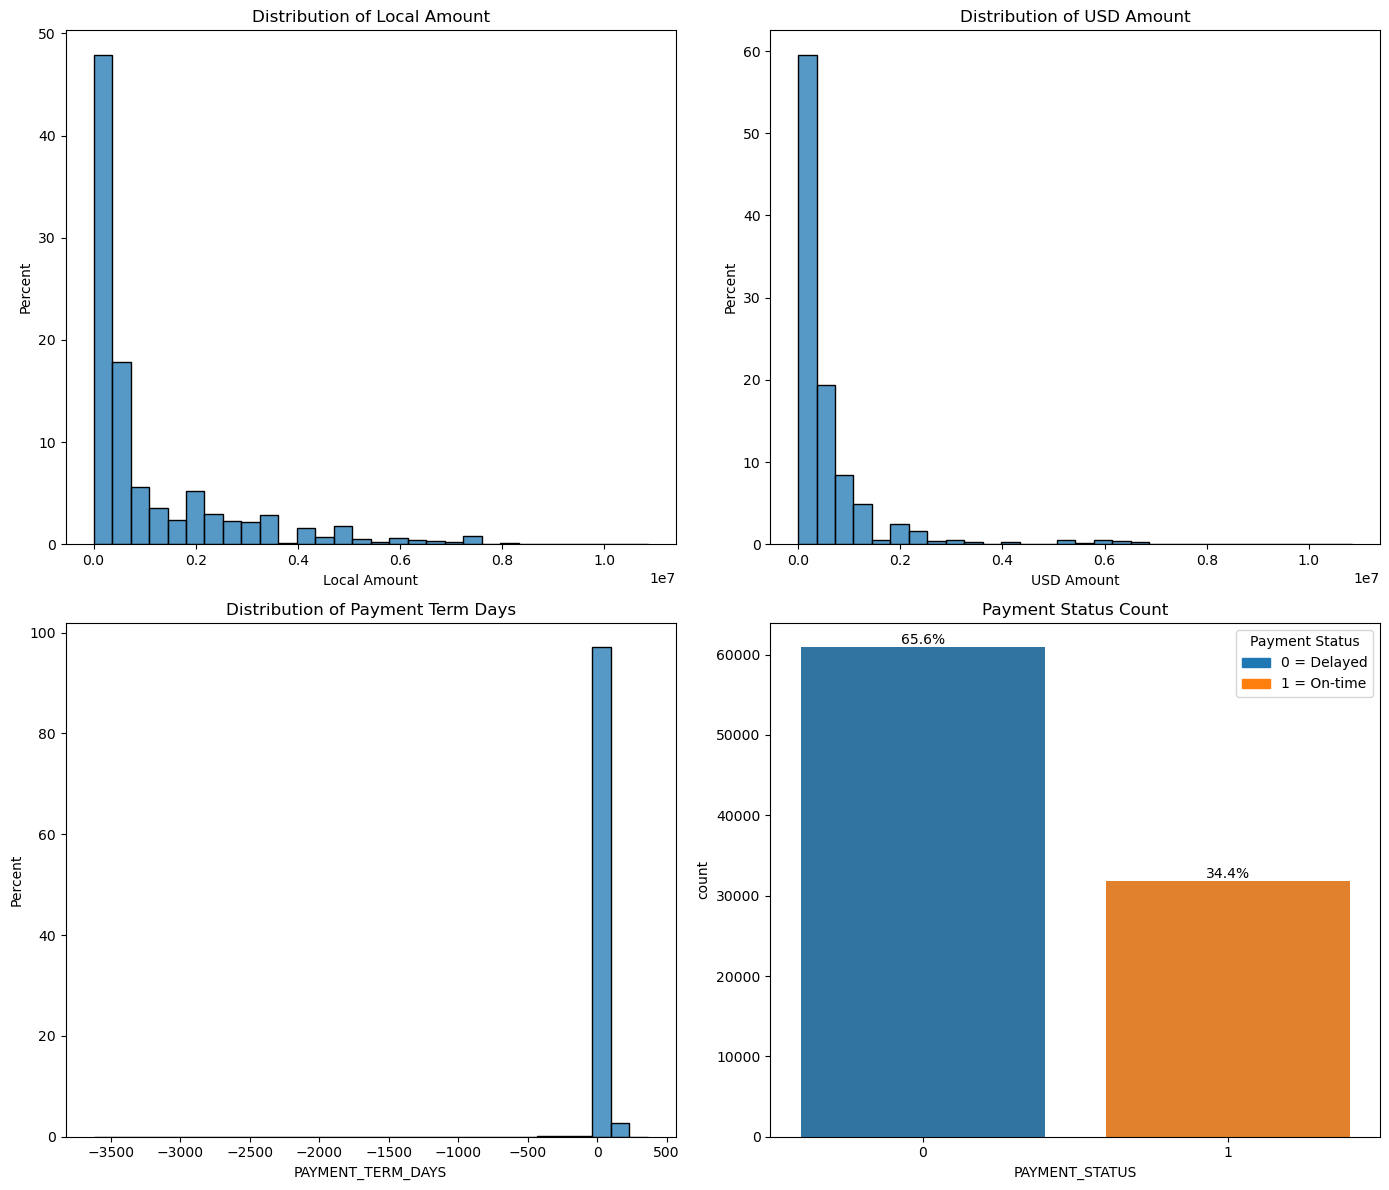

In [545]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Distribution of Local Amount with density
sns.histplot(data['Local Amount'], bins=30, kde=False, ax=axes[0, 0], stat='percent')
axes[0, 0].set_title('Distribution of Local Amount')

# Distribution of USD Amount with density
sns.histplot(data['USD Amount'], bins=30, kde=False, ax=axes[0, 1], stat='percent')
axes[0, 1].set_title('Distribution of USD Amount')

# Distribution of Payment Term Days with density
sns.histplot(data['PAYMENT_TERM_DAYS'], bins=30, kde=False, ax=axes[1, 0], stat='percent')
axes[1, 0].set_title('Distribution of Payment Term Days')

# Payment Status Count, converting PAYMENT_STATUS to string locally
payment_status_count = sns.countplot(x=data['PAYMENT_STATUS'].astype(str), ax=axes[1, 1])
axes[1, 1].set_title('Payment Status Count')

# Calculate percentages for Payment Status Count and add annotations
total = len(data['PAYMENT_STATUS'])  # Total number of entries for normalization
for p in payment_status_count.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'  # Calculate percentage
    payment_status_count.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                                  ha='center', va='bottom')

# Adding a legend manually
handles = [plt.Rectangle((0,0),1,1, color=palette) for palette in sns.color_palette()[:2]]
labels = ['0 = Delayed', '1 = On-time']
axes[1, 1].legend(handles, labels, title='Payment Status', loc='best')

plt.tight_layout()
plt.show()


In [546]:
data['PAYMENT_STATUS'].value_counts(normalize=True)*100 #1 - On time, 0 - delayed

PAYMENT_STATUS
0    65.648509
1    34.351491
Name: proportion, dtype: float64

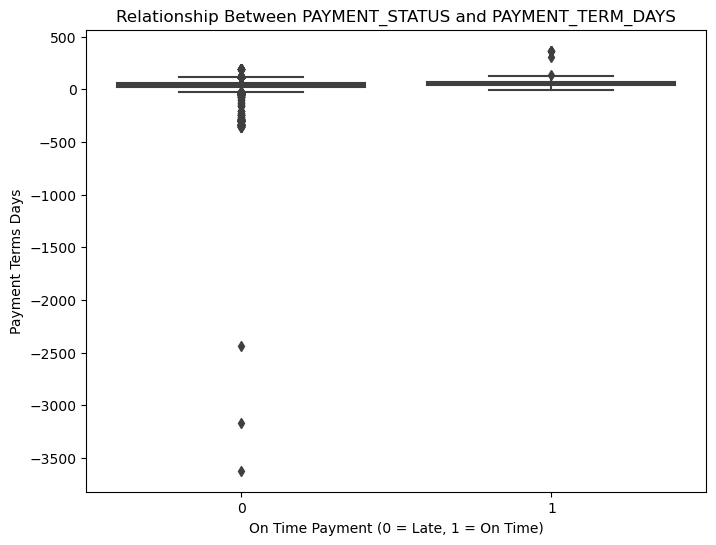

In [547]:
# Creating a boxplot to explore the relationship between On-Time Payment and Payment Terms Days
plt.figure(figsize=(8, 6))
sns.boxplot(x='PAYMENT_STATUS', y='PAYMENT_TERM_DAYS', data=data)
plt.title('Relationship Between PAYMENT_STATUS and PAYMENT_TERM_DAYS')
plt.xlabel('On Time Payment (0 = Late, 1 = On Time)')
plt.ylabel('Payment Terms Days')
plt.show()

## Exploratory Data Analysis Summary
### 1. Target Variable Distribution:

Approximately 66% of the payments are late (represented by 1).
Around 34% of the payments are on time (represented by 0).
### 2. Summary Statistics for Key Numerical Features:

#### Local Amount and USD Amount:
Mean local amount is approximately 1.067 million, with a wide standard deviation, indicating significant variance in invoice values.
The distribution of both local and USD amounts is skewed, with a concentration of values at the lower end and a long tail towards higher values.
#### Payment Term Days:
The average payment term is around 42 days, with a standard deviation of 61 days, indicating a wide range of payment terms.
The distribution shows that the majority of terms are concentrated around 30 to 60 days.
There are negative values, which might represent data entry errors or special cases where due dates are set before invoice creation dates.
### 3. Distributions and Relationships:

Both Local Amount and USD Amount distributions show heavy right-skewness, typical for financial data, where a large number of transactions involve smaller amounts and a few transactions involve very large amounts.
Payment Term Days are also right-skewed with most terms clustering around typical 30, 45, and 60-day periods.

### 4. Relationship Between On-Time Payment and Payment Terms Days:
The boxplot reveals that the distribution of payment terms days is quite similar for both on-time and late payments. However, it looks like on-time payments have a slightly higher median and a wider range in payment terms compared to late payments, suggesting that longer payment terms might be slightly more manageable for on-time payments. 

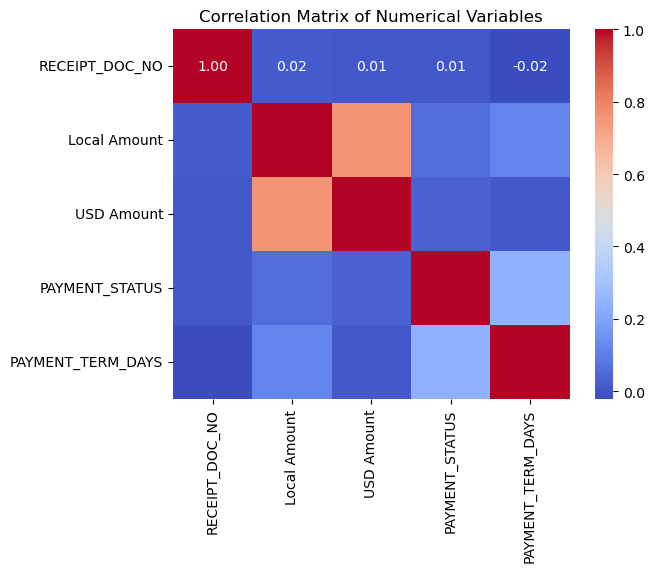

In [548]:
# Calculate correlation matrix for numerical variables
numerical_columns = data.select_dtypes(include=[np.number])
numerical_columns = numerical_columns.drop(columns=['CUSTOMER_NUMBER'])
correlation_matrix = numerical_columns.corr()

# Plotting the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()


### Correlation Analysis
The heatmap of the correlation matrix provides insights into the relationships between numerical features:
PAYMENT_STATUS and PAYMENT_TERM_DAYS show some degree of correlation, suggesting that as the number of days from invoice creation to due date increases, the likelihood of a payment being late also increases, though the correlation is not very strong.

Local Amount and USD Amount are highly correlated, as expected since these are just currency conversions of the same underlying values.
The other variables show less significant correlations with PAYMENT_STATUS, indicating that while useful, they are not as directly predictive of late payments as PAYMENT_TERM_DAYS.


## Comparison of PAYMENT_TERM_DAYS by PAYMENT_TERM Categories

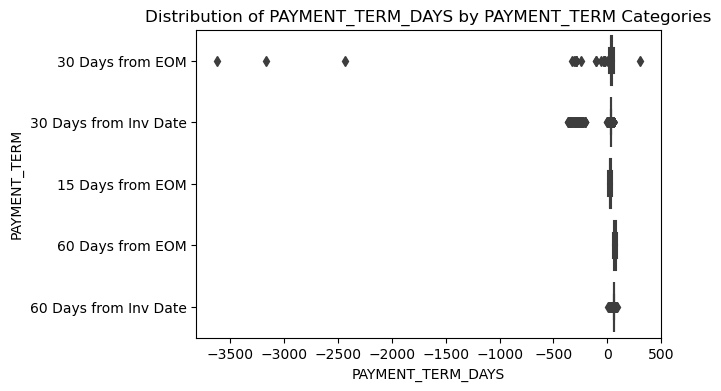

In [549]:
# Distribution of PAYMENT_TERM_DAYS by different PAYMENT_TERM categories to understand their relationship
# Due to the large number of unique payment terms, we will sample a few common ones to visualise

# Sample some common payment terms for comparison
common_payment_terms = data['PAYMENT_TERM'].value_counts().nlargest(5).index
sampled_data = data[data['PAYMENT_TERM'].isin(common_payment_terms)]

# Set up the figure for plots
fig, ax = plt.subplots(figsize=(6, 4))

# Boxplot of PAYMENT_TERM_DAYS by PAYMENT_TERM categories
sns.boxplot(x='PAYMENT_TERM_DAYS', y='PAYMENT_TERM', data=sampled_data, ax=ax)
ax.set_title('Distribution of PAYMENT_TERM_DAYS by PAYMENT_TERM Categories')
ax.set_xlabel('PAYMENT_TERM_DAYS')
ax.set_ylabel('PAYMENT_TERM')

plt.show()

In [550]:
# Filtering the data to include only negative PAYMENT_TERM_DAYS
negative_payment_terms_data = data[data['PAYMENT_TERM_DAYS'] < 0]

# Overview of the data with only negative PAYMENT_TERM_DAYS
negative_payment_terms_data.describe(include='all')


,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,PAYMENT_STATUS,PAYMENT_TERM_DAYS
count,3258,3258,3258.000000,3.258000e+03,3258,3258,3.258000e+03,3.258000e+03,3258,3258,3258,3258,3258,3258,3258,3258.000000,3258.000000
unique,7,139,NaN,NaN,NaN,5,NaN,NaN,2305,NaN,NaN,10,2,7,2,NaN,NaN
top,WIRE,YOUG Corp,NaN,NaN,NaN,SAR,NaN,NaN,2.842E+11,NaN,NaN,Immediate Payment,INV,SAR,Non Goods,NaN,NaN
freq,3101,1480,NaN,NaN,NaN,1705,NaN,NaN,251,NaN,NaN,2164,2471,1717,2711,NaN,NaN
mean,NaN,NaN,22776.530694,1.552170e+11,2021-03-28 15:40:33.149171456,NaN,4.061193e+05,2.805299e+05,NaN,2021-01-14 11:02:32.486188032,2020-12-26 00:42:25.856353536,NaN,NaN,NaN,NaN,0.016575,-19.430632
min,NaN,NaN,1044.000000,1.000000e+11,2021-01-05 00:00:00,NaN,1.688000e+01,4.901293e+00,NaN,2016-02-09 00:00:00,2010-10-30 00:00:00,NaN,NaN,NaN,NaN,0.000000,-3622.000000
25%,NaN,NaN,4003.000000,1.280000e+11,2021-02-15 00:00:00,NaN,1.486754e+05,3.963886e+04,NaN,2020-12-31 00:00:00,2020-12-28 00:00:00,NaN,NaN,NaN,NaN,0.000000,-11.000000
50%,NaN,NaN,34870.000000,1.280000e+11,2021-03-27 00:00:00,NaN,2.003309e+05,5.341091e+04,NaN,2021-02-01 00:00:00,2021-01-31 00:00:00,NaN,NaN,NaN,NaN,0.000000,-2.000000
75%,NaN,NaN,34870.000000,1.690000e+11,2021-05-05 00:00:00,NaN,3.111577e+05,1.664924e+05,NaN,2021-03-20 00:00:00,2021-03-13 00:00:00,NaN,NaN,NaN,NaN,0.000000,-1.000000
max,NaN,NaN,52802.000000,2.970000e+11,2021-06-30 00:00:00,NaN,6.836736e+06,6.836736e+06,NaN,2021-07-01 00:00:00,2021-06-30 00:00:00,NaN,NaN,NaN,NaN,1.000000,-1.000000


### General Characteristics
Count: There are 3,258 entries with negative payment term days.
RECEIPT_METHOD: Most payments were made via wire transfer.
CUSTOMER_NAME: A diverse set of customers is involved, with 'YOUG Corp' being the most frequent.
PAYMENT_TERM_DAYS: Values range from -1 to -3,622 days, with a mean of about -19.43 days. This suggests that invoices are often issued after the due date, or due dates are set retroactively.
IS_LATE: Approximately 98.34% of these payments are classified as late, which is quite high and may indicate systemic issues with how due dates are set or invoices are processed.
### Specific Observations
Distribution of Payment Terms: 'Immediate Payment' is the most common payment term associated with these entries, which might be misaligned with actual payment processes if the terms are not adhered to.
Currencies: SAR (Saudi Riyal) appears most frequently, suggesting a regional pattern or specific business operations impacting these transactions.
### Implications
The presence of a significant number of invoices with negative payment term days and a high rate of late payments among them suggests either a procedural issue in how payment terms are set or in how transactions are recorded. This could be a critical area for improving business processes or data management practices to enhance payment efficiencies.

In [551]:
data = data[data['PAYMENT_TERM_DAYS'] > 0] # dropping these rows which are irrelevant for further analysis

In [552]:
data.shape

(80545, 17)

In [553]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80545 entries, 0 to 93907
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         80545 non-null  object        
 1   CUSTOMER_NAME          80545 non-null  object        
 2   CUSTOMER_NUMBER        80545 non-null  int64         
 3   RECEIPT_DOC_NO         80545 non-null  float64       
 4   RECEIPT_DATE           80545 non-null  datetime64[ns]
 5   CURRENCY_CODE          80545 non-null  object        
 6   Local Amount           80545 non-null  float64       
 7   USD Amount             80545 non-null  float64       
 8   INVOICE_ALLOCATED      80545 non-null  object        
 9   INVOICE_CREATION_DATE  80545 non-null  datetime64[ns]
 10  DUE_DATE               80545 non-null  datetime64[ns]
 11  PAYMENT_TERM           80545 non-null  object        
 12  INVOICE_CLASS          80545 non-null  object        
 13  INVOIC

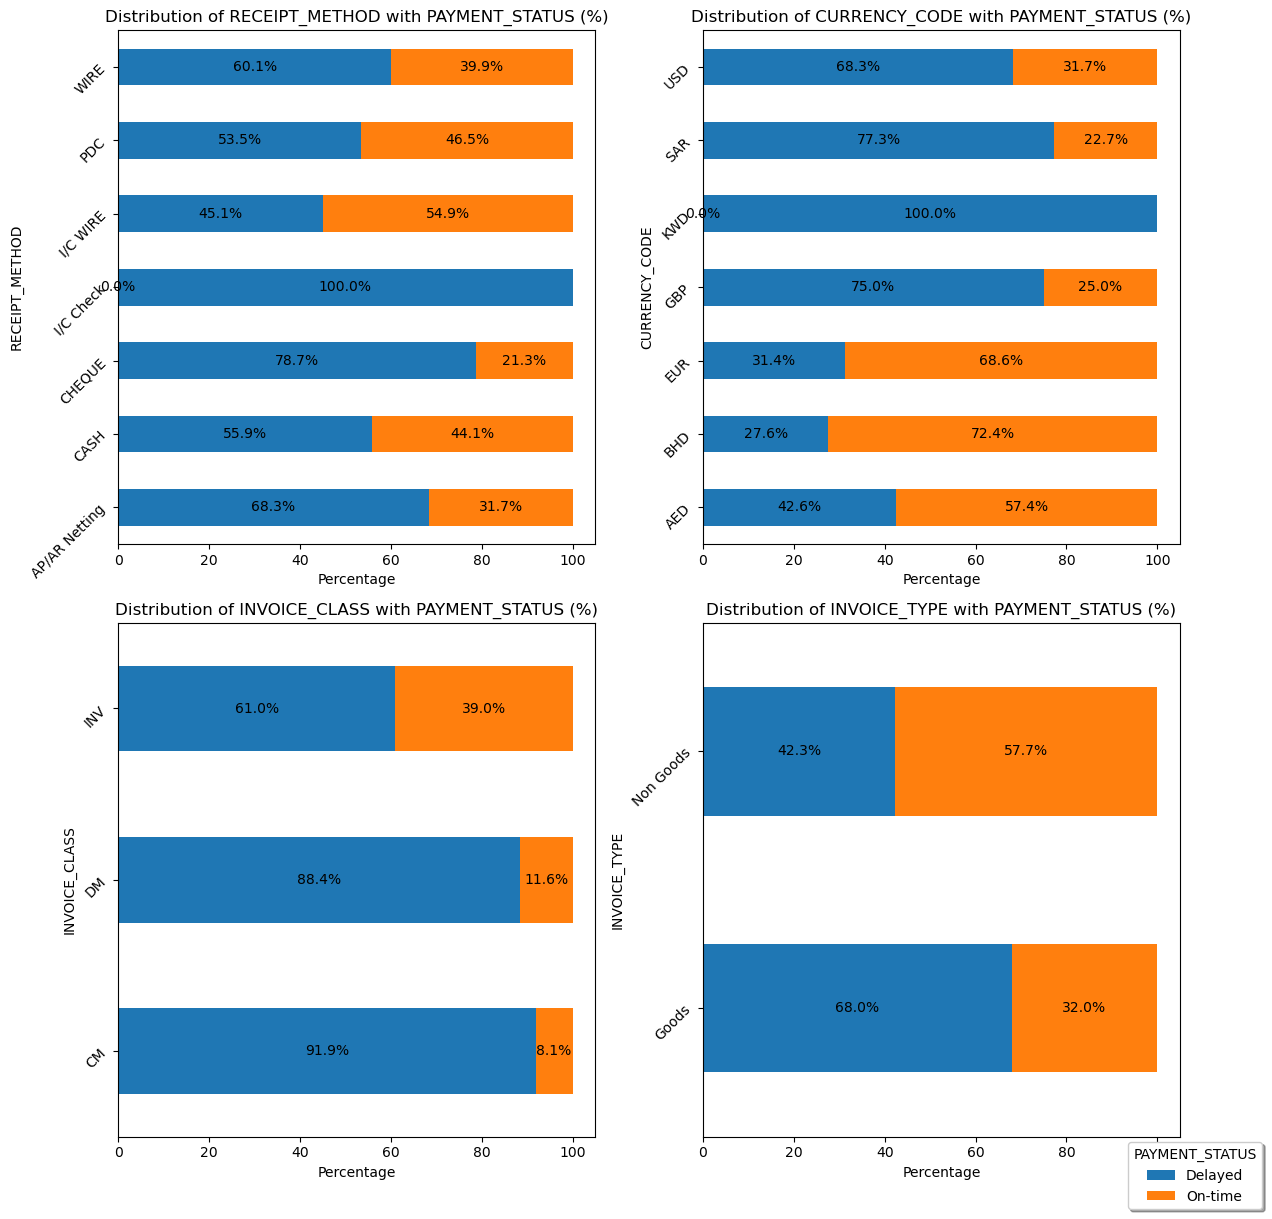

In [554]:
categorical_features = ['RECEIPT_METHOD', 'CURRENCY_CODE', 'INVOICE_CLASS', 'INVOICE_TYPE']

# Set up the figure for plots with a 2x2 layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, feature in enumerate(categorical_features):
    # Ensure the feature is treated as categorical for the purpose of plotting
    data[feature] = data[feature].astype(str)  # Convert categorical features to string if they are not

    # Get data prepared for percentage calculation
    group_data = data.groupby([feature, 'PAYMENT_STATUS']).size().unstack(fill_value=0)
    group_percent = group_data.div(group_data.sum(axis=1), axis=0) * 100  # Calculate the percentage

    # Plotting
    group_percent.plot(kind='barh', stacked=True, ax=axes[i], legend=False)
    axes[i].set_title(f'Distribution of {feature} with PAYMENT_STATUS (%)')
    axes[i].set_xlabel('Percentage')
    axes[i].set_ylabel(feature)

    # Annotate the bars with percentage values
    for patches in axes[i].containers:
        axes[i].bar_label(patches, fmt='%.1f%%', label_type='center')

    # Rotate y-axis tick labels
    axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=45)

# Handling the legend manually to add specific labels
handles, labels = axes[0].get_legend_handles_labels()
new_labels = ['Delayed', 'On-time'] if '1' in labels else labels
fig.legend(handles, new_labels, title='PAYMENT_STATUS', loc='upper center', bbox_to_anchor=(1, 0.05), fancybox=True, shadow=True)

# Adjust layout to prevent overlap and ensure everything fits nicely
plt.tight_layout()
plt.show()


## Exploratory Data Analysis (EDA) for several categorical variables against the target variable PAYMENT_STATUS:

### RECEIPT_METHOD: 
The method of receipt seems to show some variation in payment timeliness. Certain methods might be more conducive to on-time payments, potentially due to the efficiency or ease of processing.
### CURRENCY_CODE: 
Payment timeliness also appears to vary with the currency, which could reflect differences in banking processes or economic factors specific to regions using different currencies.
### INVOICE_CLASS: 
Different classes of invoices show distinct patterns in their payment statuses, suggesting that the nature of the invoice (like goods, services, etc.) impacts payment behaviour.
### INVOICE_TYPE: 
Similarly, the type of invoice influences whether payments are made on time or are delayed, highlighting the importance of the transaction context.

<Figure size 1500x3000 with 0 Axes>

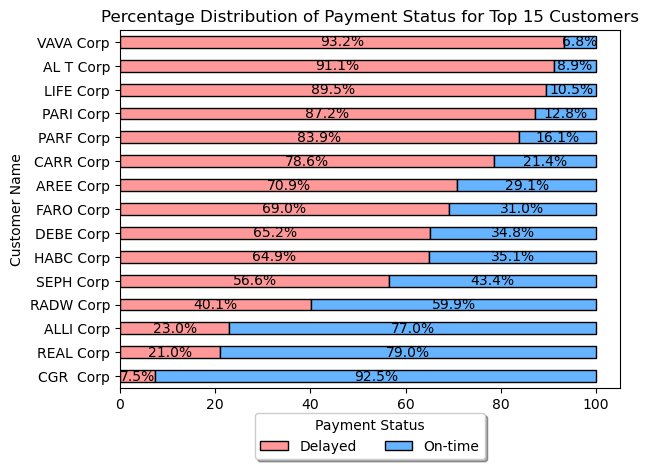

In [555]:
data_1= data.copy()
data_1['PAYMENT_STATUS'] = data_1['PAYMENT_STATUS'].astype(str).replace({'0':'Delayed','1':'On-time'})

# Calculate the count of transactions per customer
customer_payment_counts = data_1['CUSTOMER_NAME'].value_counts().nlargest(15)

# Filter data to include only the top 15 customers by transaction volume
top_customers_data = data_1[data_1['CUSTOMER_NAME'].isin(customer_payment_counts.index)]

# Calculate the percentage of each payment status per customer
top_customers_grouped = top_customers_data.groupby(['CUSTOMER_NAME', 'PAYMENT_STATUS']).size().unstack(fill_value=0)
top_customers_grouped = top_customers_grouped.div(top_customers_grouped.sum(axis=1), axis=0) * 100  # Convert counts to percentages

# Sort the DataFrame by 'Delayed' in descending order
top_customers_grouped = top_customers_grouped.sort_values('Delayed', ascending=True)

# Plot distribution of payments for each of the top customers using horizontal bar plot
plt.figure(figsize=(15, 30))
bar_plot = top_customers_grouped.plot.barh(stacked=True, color=['#ff9999','#66b3ff'], edgecolor='black')

# Adding value labels on each bar
for rect in bar_plot.patches:
    # Find where to place the text
    width = rect.get_width()
    if width > 5:  # adjust text visibility threshold
        x = rect.get_x() + width / 2
        y = rect.get_y() + rect.get_height() / 2
        label_text = f'{width:.1f}%'  # format the text
        bar_plot.text(x, y, label_text, ha='center', va='center', color='black')

plt.title('Percentage Distribution of Payment Status for Top 15 Customers')
plt.xlabel('Percentage of Transactions (%)')
plt.ylabel('Customer Name')
plt.legend(title='Payment Status',loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.show()

## VAVA Corp has the highest % of Delayed payments among the top 15 customers with dealyed payments. 
## CGR Group is the lowest % among the top 15 customers with dealyed payments. 

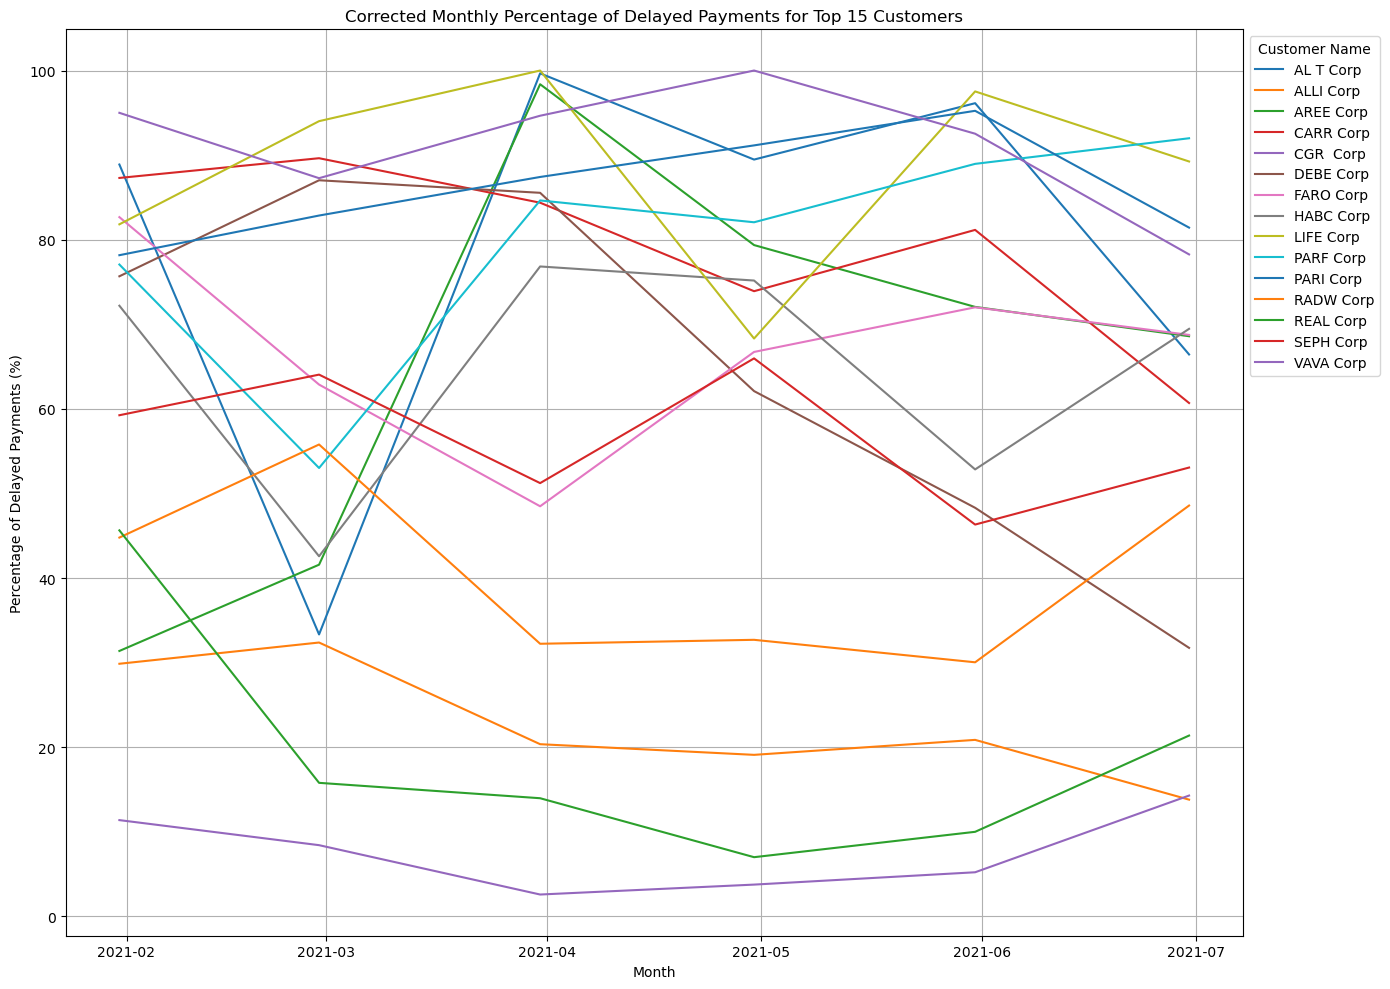

In [556]:
# Filter data to include only delayed payments for the top 15 customers
delayed_payments_data_corrected = data_1[(data_1['CUSTOMER_NAME'].isin(customer_payment_counts.index)) & 
                                                        (data_1['PAYMENT_STATUS'] == 'Delayed')]

# Correct resampling of the data on a monthly basis and calculate the percentage of delayed payments per month for each customer
monthly_delayed_payments_corrected = delayed_payments_data_corrected.groupby(['CUSTOMER_NAME', pd.Grouper(key='RECEIPT_DATE', freq='M')]).size()
total_monthly_transactions_corrected = data_1[data_1['CUSTOMER_NAME'].isin(customer_payment_counts.index)].groupby(['CUSTOMER_NAME', pd.Grouper(key='RECEIPT_DATE', freq='M')]).size()

# Correct calculation of the percentage of delayed payments
monthly_delayed_percentage_corrected = (monthly_delayed_payments_corrected / total_monthly_transactions_corrected) * 100
monthly_delayed_percentage_corrected = monthly_delayed_percentage_corrected.unstack(level=0).fillna(0)  # unstack for plotting, fill NA for months with no transactions

# Plotting the time series data for each customer correctly
plt.figure(figsize=(14, 10))
for customer in monthly_delayed_percentage_corrected.columns:
    plt.plot(monthly_delayed_percentage_corrected.index, monthly_delayed_percentage_corrected[customer], label=customer)

plt.title('Corrected Monthly Percentage of Delayed Payments for Top 15 Customers')
plt.xlabel('Month')
plt.ylabel('Percentage of Delayed Payments (%)')
plt.legend(title='Customer Name', loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True)
plt.tight_layout()
plt.show()


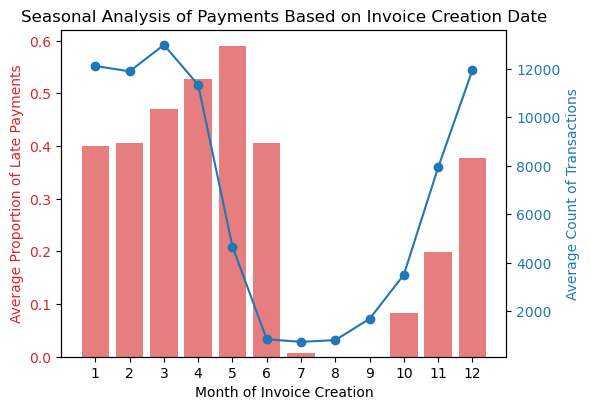

In [557]:
# Extract month from Invoice Creation Date
data['Invoice_Month'] = data['INVOICE_CREATION_DATE'].dt.month

# Group data by the new invoice month to calculate average proportions of late payments and transaction counts per month
invoice_seasonal_data = data.groupby('Invoice_Month')['PAYMENT_STATUS'].agg(['mean', 'count']).reset_index()

# Setting up the figure for the seasonality plot based on Invoice Creation Date
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plotting the average proportion of late payments by invoice month
color = 'tab:red'
ax1.set_xlabel('Month of Invoice Creation')
ax1.set_ylabel('Average Proportion of Late Payments', color=color)
ax1.bar(invoice_seasonal_data['Invoice_Month'].astype(str), invoice_seasonal_data['mean'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a twin axis to plot the average count of transactions by invoice month
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Count of Transactions', color=color)
ax2.plot(invoice_seasonal_data['Invoice_Month'].astype(str), invoice_seasonal_data['count'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Seasonal Analysis of Payments Based on Invoice Creation Date')
plt.show()

## Average Proportion of Late Payments:
Late Payments (Red Bars): Similar to the previous analysis with Receipt Date, there is noticeable seasonality in late payments based on Invoice Creation Date. Certain months show higher averages of late payments, potentially indicating when billing practices or financial pressures affect payment behaviors.
### Average Transaction Volume:
Transaction Count (Blue Line): The pattern of transaction volumes also shows seasonal fluctuations, which might relate to business cycles, sales initiatives, or financial reporting periods.
### Key Observations:
Alignment with Business Cycles: The peaks in late payments might align with typical business cycles, such as end-of-quarter financial periods or seasonal sales, impacting the invoice creation practices.
Cyclical Transaction Volumes: As before, transaction volumes vary across the year, suggesting strategic business activities like promotions or contract renewals often occur in specific months.
### Implications:
This insight into the relationship between invoice creation timing and payment timeliness can inform more effective billing cycle adjustments and proactive cash flow management strategies. Adjusting invoicing practices to accommodate predictable fluctuations in payment behaviors could mitigate risks of late payments.

In [558]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80545 entries, 0 to 93907
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         80545 non-null  object        
 1   CUSTOMER_NAME          80545 non-null  object        
 2   CUSTOMER_NUMBER        80545 non-null  int64         
 3   RECEIPT_DOC_NO         80545 non-null  float64       
 4   RECEIPT_DATE           80545 non-null  datetime64[ns]
 5   CURRENCY_CODE          80545 non-null  object        
 6   Local Amount           80545 non-null  float64       
 7   USD Amount             80545 non-null  float64       
 8   INVOICE_ALLOCATED      80545 non-null  object        
 9   INVOICE_CREATION_DATE  80545 non-null  datetime64[ns]
 10  DUE_DATE               80545 non-null  datetime64[ns]
 11  PAYMENT_TERM           80545 non-null  object        
 12  INVOICE_CLASS          80545 non-null  object        
 13  INVOIC

In [559]:
data.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,PAYMENT_STATUS,PAYMENT_TERM_DAYS,Invoice_Month
0,WIRE,C EA Corp,37403,1.421000e+10,2021-04-20,USD,370990.92,101018.63040,14200000001,2020-11-02,2020-12-30,30 Days from EOM,INV,AED,Non Goods,0,58,11
1,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,SAR,183750.00,48990.21133,99200000043,2020-12-29,2021-01-28,30 Days from Inv Date,INV,SAR,Non Goods,0,30,12
2,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,SAR,157500.00,41991.60971,99210000003,2021-01-30,2021-03-01,30 Days from Inv Date,INV,SAR,Non Goods,1,30,1
3,WIRE,FARO Corp,1409,9.921000e+10,2021-01-31,SAR,157500.00,41991.60971,99200000038,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,0,30,12
4,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,SAR,157500.00,41991.60971,99200000039,2020-12-15,2021-01-14,30 Days from Inv Date,INV,SAR,Non Goods,0,30,12


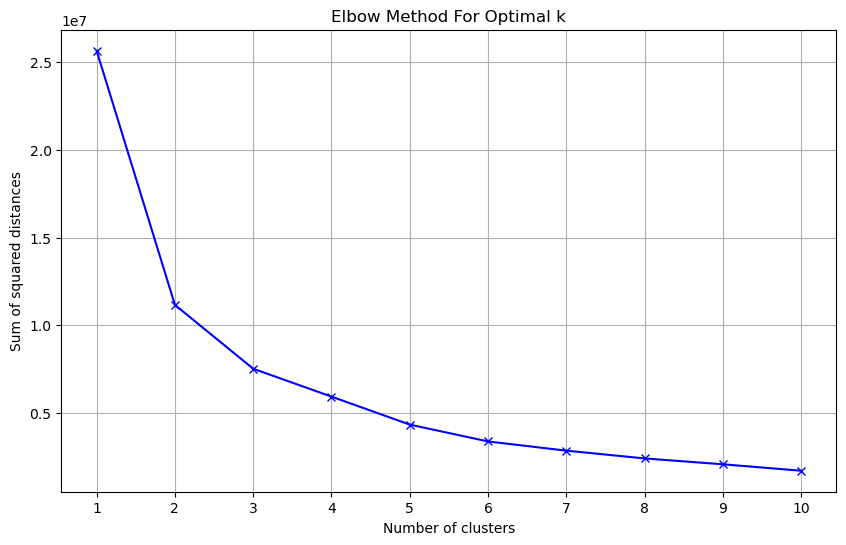

In [560]:
from sklearn.cluster import KMeans
# Calculate the payment time in days for each invoice
data['Payment_Time_Days'] = (data['RECEIPT_DATE'] - data['INVOICE_CREATION_DATE']).dt.days

# Compute average and standard deviation of payment time for each customer
customer_stats = data.groupby('CUSTOMER_NUMBER').agg(
    Average_Payment_Time=('Payment_Time_Days', 'mean'),
    SD_Payment_Time=('Payment_Time_Days', 'std')
).fillna(0)  # Fill NaN with 0, which can happen if all records for a customer have the same payment time

# Determine the optimal number of clusters using the Elbow Method
# Range of potential clusters to test
K = range(1, 11)  # Testing from 1 to 10 clusters
sum_of_squared_distances = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(customer_stats[['Average_Payment_Time', 'SD_Payment_Time']])
    sum_of_squared_distances.append(km.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(K)  # Ensure all cluster tick marks are shown
plt.grid(True)
plt.show()

In [561]:
# After determining the optimal number of clusters from the plot, proceed with that number
optimal_k = int(input("Enter the optimal number of clusters as observed from the Elbow Plot: "))# flexibility to run the codes below with different sets of clusters

Enter the optimal number of clusters as observed from the Elbow Plot:  4


In [562]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_stats['Cluster'] = kmeans.fit_predict(customer_stats[['Average_Payment_Time', 'SD_Payment_Time']])

# Merge the cluster labels back to the original data
data = data.join(customer_stats['Cluster'], on='CUSTOMER_NUMBER')

In [563]:
# Summary statistics for each cluster
cluster_summary = customer_stats.groupby('Cluster').agg(
    Count=('Cluster', 'size'),
    Avg_Payment_Time=('Average_Payment_Time', 'mean'),
    Std_Dev_Payment_Time=('SD_Payment_Time', 'mean')
)
print(cluster_summary)

         Count  Avg_Payment_Time  Std_Dev_Payment_Time
Cluster                                               
0          785         68.450679             26.908728
1           33        571.363035             59.086723
2           62        272.043761            257.863555
3            6       1143.291486            243.479307


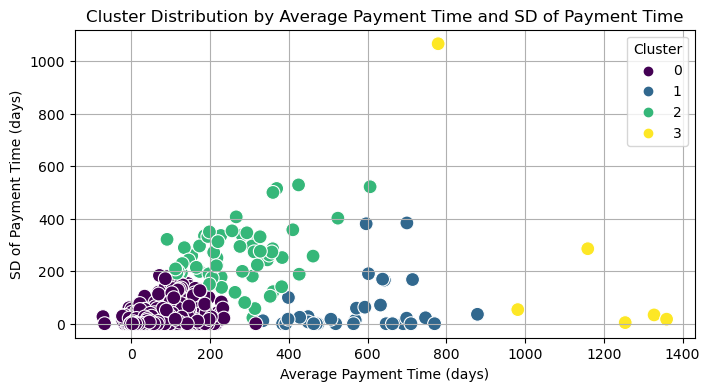

In [564]:
# Visualizing the clusters
# Distribution of Average Payment Time and Standard Deviation by Cluster
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Average_Payment_Time', y='SD_Payment_Time', hue='Cluster', data=customer_stats, palette='viridis', s=100)
plt.title('Cluster Distribution by Average Payment Time and SD of Payment Time')
plt.xlabel('Average Payment Time (days)')
plt.ylabel('SD of Payment Time (days)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

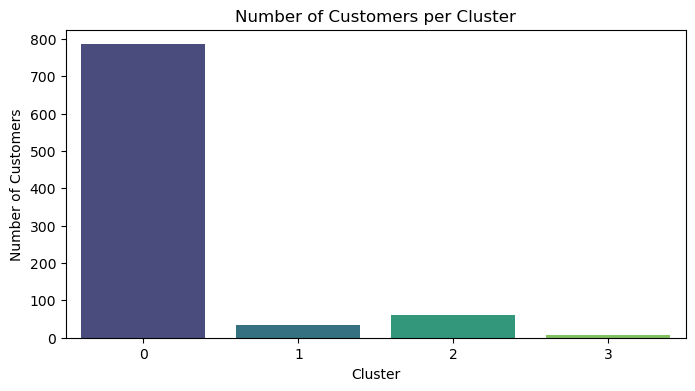

In [565]:
# Visualize the number of customers per cluster
plt.figure(figsize=(8, 4))
sns.countplot(x='Cluster', data=customer_stats, palette='viridis')
plt.title('Number of Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

In [566]:
data = data.drop(columns=['CURRENCY_CODE','RECEIPT_METHOD','RECEIPT_DOC_NO','INVOICE_ALLOCATED','INVOICE_TYPE','RECEIPT_DATE','INVOICE_CREATION_DATE','DUE_DATE','Payment_Time_Days']) # as per business sense, these columns are not useful.

In [567]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80545 entries, 0 to 93907
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_NAME          80545 non-null  object 
 1   CUSTOMER_NUMBER        80545 non-null  int64  
 2   Local Amount           80545 non-null  float64
 3   USD Amount             80545 non-null  float64
 4   PAYMENT_TERM           80545 non-null  object 
 5   INVOICE_CLASS          80545 non-null  object 
 6   INVOICE_CURRENCY_CODE  80545 non-null  object 
 7   PAYMENT_STATUS         80545 non-null  int32  
 8   PAYMENT_TERM_DAYS      80545 non-null  int64  
 9   Invoice_Month          80545 non-null  int32  
 10  Cluster                80545 non-null  int32  
dtypes: float64(2), int32(3), int64(2), object(4)
memory usage: 6.5+ MB


## Model Building

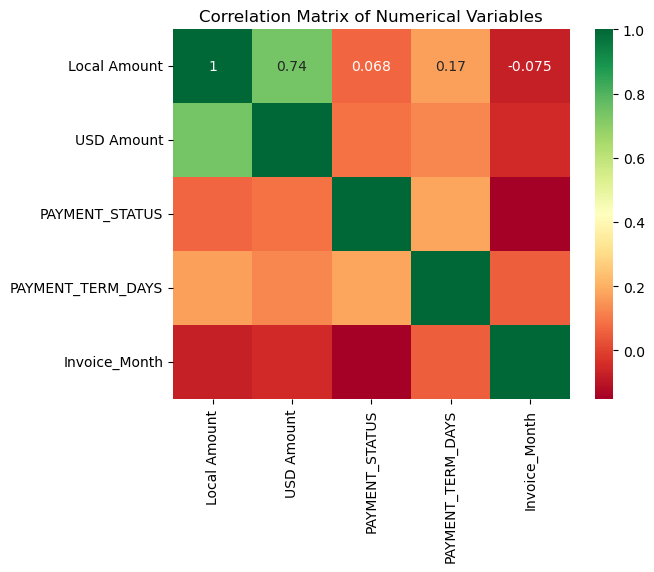

In [568]:
numerical_data = data.select_dtypes(include=[np.number])
numerical_data=numerical_data.drop(columns=['CUSTOMER_NUMBER','Cluster'])
# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

# Plot the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', cbar=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()


Local Amount and USD Amount are highly correlated. Local Amount to be dropped for analysis
Customer Number has no relevance for analysis.                                                   
Datetime columns area also not relevant directly.

In [569]:
data = data.drop(columns=['Local Amount'])

In [570]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80545 entries, 0 to 93907
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_NAME          80545 non-null  object 
 1   CUSTOMER_NUMBER        80545 non-null  int64  
 2   USD Amount             80545 non-null  float64
 3   PAYMENT_TERM           80545 non-null  object 
 4   INVOICE_CLASS          80545 non-null  object 
 5   INVOICE_CURRENCY_CODE  80545 non-null  object 
 6   PAYMENT_STATUS         80545 non-null  int32  
 7   PAYMENT_TERM_DAYS      80545 non-null  int64  
 8   Invoice_Month          80545 non-null  int32  
 9   Cluster                80545 non-null  int32  
dtypes: float64(1), int32(3), int64(2), object(4)
memory usage: 5.8+ MB


In [571]:
# Select categorical columns and display unique values for each
categorical_columns = data.select_dtypes(include='object').columns
categorical_columns = categorical_columns.drop('CUSTOMER_NAME')
unique_values = {column: data[column].nunique() for column in categorical_columns}
print("Unique values in each categorical column:", unique_values)

Unique values in each categorical column: {'PAYMENT_TERM': 36, 'INVOICE_CLASS': 3, 'INVOICE_CURRENCY_CODE': 10}


Column 'PAYMENT_TERM' has already been encoded through Separate Column 'PAYMENT_TERM_DAYS'.Can be dropped from further analysis.

In [572]:
data = data.drop(columns=['PAYMENT_TERM'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80545 entries, 0 to 93907
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_NAME          80545 non-null  object 
 1   CUSTOMER_NUMBER        80545 non-null  int64  
 2   USD Amount             80545 non-null  float64
 3   INVOICE_CLASS          80545 non-null  object 
 4   INVOICE_CURRENCY_CODE  80545 non-null  object 
 5   PAYMENT_STATUS         80545 non-null  int32  
 6   PAYMENT_TERM_DAYS      80545 non-null  int64  
 7   Invoice_Month          80545 non-null  int32  
 8   Cluster                80545 non-null  int32  
dtypes: float64(1), int32(3), int64(2), object(3)
memory usage: 5.2+ MB


# Model Building

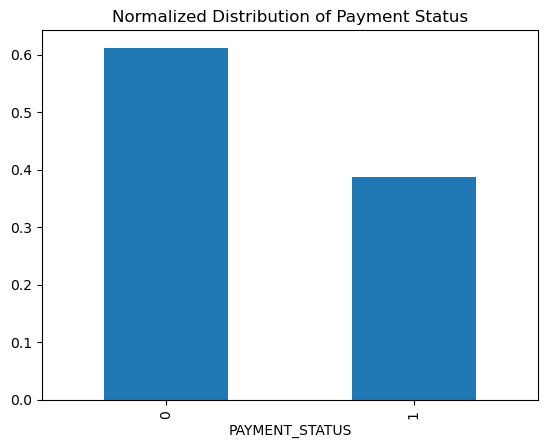

In [573]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = data.drop('PAYMENT_STATUS', axis=1)
y = data['PAYMENT_STATUS']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y.value_counts(normalize=True).plot(kind='bar').set(title='Normalized Distribution of Payment Status')
plt.show()

In [574]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56381 entries, 87914 to 19519
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_NAME          56381 non-null  object 
 1   CUSTOMER_NUMBER        56381 non-null  int64  
 2   USD Amount             56381 non-null  float64
 3   INVOICE_CLASS          56381 non-null  object 
 4   INVOICE_CURRENCY_CODE  56381 non-null  object 
 5   PAYMENT_TERM_DAYS      56381 non-null  int64  
 6   Invoice_Month          56381 non-null  int32  
 7   Cluster                56381 non-null  int32  
dtypes: float64(1), int32(2), int64(2), object(3)
memory usage: 3.4+ MB


In [575]:
X_train.shape, X_test.shape

((56381, 8), (24164, 8))

In [576]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, OneHotEncoder
import pandas as pd

# Assuming 'X_train' is your DataFrame and already defined

# Specify the columns to include in transformations
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.drop(['CUSTOMER_NUMBER', 'Cluster'])
categorical_cols = X_train.select_dtypes(include=[object]).columns.drop('CUSTOMER_NAME')

# Define the transformation pipelines
numerical_pipeline = Pipeline([
    ('power_transformer', PowerTransformer()),
    ('scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Create a ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Fit and transform the data
X_train_transformed = preprocessor.fit_transform(X_train)

# Generate feature names for the DataFrame from the transformed data
num_features = list(numerical_cols)
cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out()
all_features = num_features + list(cat_features)

# Create the DataFrame from the transformed data
X_train_df = pd.DataFrame(X_train_transformed, columns=all_features)


In [577]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56381 entries, 0 to 56380
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   USD Amount                 56381 non-null  float64
 1   PAYMENT_TERM_DAYS          56381 non-null  float64
 2   Invoice_Month              56381 non-null  float64
 3   INVOICE_CLASS_CM           56381 non-null  float64
 4   INVOICE_CLASS_DM           56381 non-null  float64
 5   INVOICE_CLASS_INV          56381 non-null  float64
 6   INVOICE_CURRENCY_CODE_AED  56381 non-null  float64
 7   INVOICE_CURRENCY_CODE_BHD  56381 non-null  float64
 8   INVOICE_CURRENCY_CODE_EUR  56381 non-null  float64
 9   INVOICE_CURRENCY_CODE_GBP  56381 non-null  float64
 10  INVOICE_CURRENCY_CODE_JOD  56381 non-null  float64
 11  INVOICE_CURRENCY_CODE_KWD  56381 non-null  float64
 12  INVOICE_CURRENCY_CODE_QAR  56381 non-null  float64
 13  INVOICE_CURRENCY_CODE_SAR  56381 non-null  flo

In [578]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, recall_score

# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=42,max_iter=1000,n_jobs=-1)
# Perform cross-validation and evaluate recall
recall_scores = cross_val_score(log_reg, X_train_df, y_train, n_jobs=-1,cv=5, scoring='recall')
print("Average Recall Score:", np.mean(recall_scores))
# Fit the model on the entire training set
log_reg.fit(X_train_df, y_train)
# Predict on the training set to get the confusion matrix and classification report
y_pred = log_reg.predict(X_train_df)
# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:\n", conf_matrix)
# Classification Report
class_report = classification_report(y_train, y_pred)
print("Classification Report:\n", class_report)
# Recall Score
recall = recall_score(y_train, y_pred)
print("Recall Score:", recall)


Average Recall Score: 0.4503747444923915
Confusion Matrix:
 [[28444  5922]
 [12112  9903]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.83      0.76     34366
           1       0.63      0.45      0.52     22015

    accuracy                           0.68     56381
   macro avg       0.66      0.64      0.64     56381
weighted avg       0.67      0.68      0.67     56381

Recall Score: 0.4498296615943675


In [579]:
X_train_df.shape[1]

16

In [580]:
%%time
#Cross Validation for feature selection
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, recall_score
rfecv=RFECV(estimator=log_reg,cv=4,scoring=make_scorer(recall_score),n_jobs=-1)

rfecv.fit(X_train_df, y_train)


CPU times: total: 328 ms
Wall time: 32 s


RFECV(cv=4,
      estimator=LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
      n_jobs=-1, scoring=make_scorer(recall_score))

In [581]:
rfecv.n_features_

8

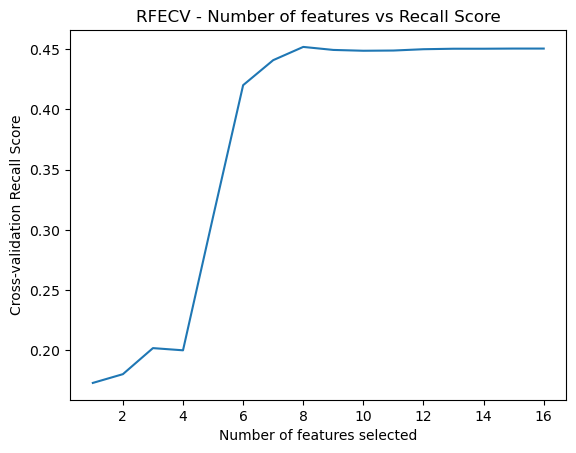

In [582]:
plt.title('RFECV - Number of features vs Recall Score')
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation Recall Score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [583]:
selected_features_log = X_train_df.columns[rfecv.support_]
selected_features_log # Optimum features identified using Logistic Regression 

Index(['PAYMENT_TERM_DAYS', 'Invoice_Month', 'INVOICE_CLASS_INV',
       'INVOICE_CURRENCY_CODE_AED', 'INVOICE_CURRENCY_CODE_BHD',
       'INVOICE_CURRENCY_CODE_EUR', 'INVOICE_CURRENCY_CODE_JOD',
       'INVOICE_CURRENCY_CODE_ZAR'],
      dtype='object')

In [584]:
%%time
# Now fitting Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the RandomForest model on the training data using only the selected features
random_forest.fit(X_train_df, y_train)

# Evaluate using cross-validation on the training data
recall_scorer = make_scorer(recall_score)
cv_recall_scores = cross_val_score(random_forest, X_train_df, y_train, cv=5, scoring=recall_scorer,n_jobs=-1)

print("Average Recall Score (CV):", cv_recall_scores.mean())


Average Recall Score (CV): 0.8411083352259823
CPU times: total: 10.2 s
Wall time: 15.4 s


In [585]:
# Make predictions on the training set itself
y_pred_train = random_forest.predict(X_train_df)

# Now, evaluate these predictions against y_train
print("Confusion Matrix on Training Set:\n", confusion_matrix(y_train, y_pred_train))
print("Classification Report on Training Set:\n", classification_report(y_train, y_pred_train))
print("Recall Score on Training Set:", recall_score(y_train, y_pred_train))


Confusion Matrix on Training Set:
 [[33829   537]
 [ 1856 20159]]
Classification Report on Training Set:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     34366
           1       0.97      0.92      0.94     22015

    accuracy                           0.96     56381
   macro avg       0.96      0.95      0.95     56381
weighted avg       0.96      0.96      0.96     56381

Recall Score on Training Set: 0.9156938451056098


In [586]:
#Significant improvement is observed on RandomForest Model.

In [587]:
%%time
# Feature Selection for Random Forest Model

rfecv = RFECV(estimator=random_forest, cv=4, scoring='recall',n_jobs=-1)
rfecv.fit(X_train_df, y_train)

# RFECV identifies which features are most important
selected_features_rf = X_train_df.columns[rfecv.support_]

print("Selected Features:", selected_features_rf)


Selected Features: Index(['USD Amount', 'PAYMENT_TERM_DAYS', 'Invoice_Month', 'INVOICE_CLASS_INV',
       'INVOICE_CURRENCY_CODE_AED', 'INVOICE_CURRENCY_CODE_EUR',
       'INVOICE_CURRENCY_CODE_KWD', 'INVOICE_CURRENCY_CODE_SAR',
       'INVOICE_CURRENCY_CODE_USD'],
      dtype='object')
CPU times: total: 1min 41s
Wall time: 2min 36s


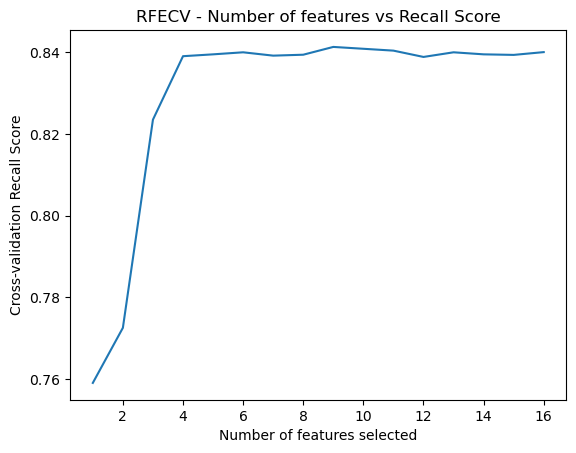

In [588]:
plt.title('RFECV - Number of features vs Recall Score')
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation Recall Score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [589]:
# HyperParameter tuning

In [590]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
X_train_selected = X_train_df[selected_features_rf]

# Set up the parameter grid to sample from during fitting
param_dist = {
    'n_estimators': sp_randint(100, 500),   # Number of trees in the forest
    'max_features': sp_randint(1, len(selected_features_rf)),  # Max number of features considered for splitting a node
    'max_depth': [3, None],  # Maximum depth of each tree
    'min_samples_split': sp_randint(2, 11),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': sp_randint(1, 11),  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# RandomizedSearchCV instance
random_search = RandomizedSearchCV(random_forest, param_distributions=param_dist,verbose=True,
                                   n_iter=50, cv=3, scoring='recall', random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train_selected, y_train)

# Print the best parameters and the best model
print("Best parameters found: ", random_search.best_params_)
best_model = random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'bootstrap': False, 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 326}
CPU times: total: 1min 5s
Wall time: 9min 13s


In [591]:
# Make predictions on the training set itself
y_pred_train = best_model.predict(X_train_selected)

# Now, evaluate these predictions against y_train
print("Confusion Matrix on Training Set:\n", confusion_matrix(y_train, y_pred_train))
print("Classification Report on Training Set:\n", classification_report(y_train, y_pred_train))
print("Recall Score on Training Set:", recall_score(y_train, y_pred_train))

Confusion Matrix on Training Set:
 [[33492   874]
 [ 2361 19654]]
Classification Report on Training Set:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     34366
           1       0.96      0.89      0.92     22015

    accuracy                           0.94     56381
   macro avg       0.95      0.93      0.94     56381
weighted avg       0.94      0.94      0.94     56381

Recall Score on Training Set: 0.8927549398137633


In [592]:
# Optimized Random Forest Model

In [593]:
# Transform the test data
X_test_transformed = preprocessor.transform(X_test)

# Create the DataFrame for X_test with the previously stored feature names
X_test_df = pd.DataFrame(X_test_transformed, columns=all_features)

# Select the features as indicated by rfecv's support attribute
X_test_selected = X_test_df.iloc[:, rfecv.support_]

# Print the information about the selected test data
X_test_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24164 entries, 0 to 24163
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   USD Amount                 24164 non-null  float64
 1   PAYMENT_TERM_DAYS          24164 non-null  float64
 2   Invoice_Month              24164 non-null  float64
 3   INVOICE_CLASS_INV          24164 non-null  float64
 4   INVOICE_CURRENCY_CODE_AED  24164 non-null  float64
 5   INVOICE_CURRENCY_CODE_EUR  24164 non-null  float64
 6   INVOICE_CURRENCY_CODE_KWD  24164 non-null  float64
 7   INVOICE_CURRENCY_CODE_SAR  24164 non-null  float64
 8   INVOICE_CURRENCY_CODE_USD  24164 non-null  float64
dtypes: float64(9)
memory usage: 1.7 MB


In [594]:
from sklearn.metrics import confusion_matrix, classification_report, recall_score

# Make predictions using the best model from RandomizedSearchCV
y_pred = best_model.predict(X_test_selected)

# Evaluate the model performance
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))


Confusion Matrix:
 [[14073   857]
 [ 1485  7749]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     14930
           1       0.90      0.84      0.87      9234

    accuracy                           0.90     24164
   macro avg       0.90      0.89      0.90     24164
weighted avg       0.90      0.90      0.90     24164

Recall Score: 0.8391812865497076


Recall Score is still very High. Very Satisfactory performance in Randome Forest Model.

In [595]:
# Add back the columns for Customer Level Analysis on the Predicted Data
X_test_selected['Predicted'] = y_pred
X_test_selected['CUSTOMER_NAME'] = X_test['CUSTOMER_NAME'].values
X_test_selected['CUSTOMER_NUMBER'] = X_test['CUSTOMER_NUMBER'].values
X_test_selected['Cluster'] = X_test['Cluster'].values
X_test_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24164 entries, 0 to 24163
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   USD Amount                 24164 non-null  float64
 1   PAYMENT_TERM_DAYS          24164 non-null  float64
 2   Invoice_Month              24164 non-null  float64
 3   INVOICE_CLASS_INV          24164 non-null  float64
 4   INVOICE_CURRENCY_CODE_AED  24164 non-null  float64
 5   INVOICE_CURRENCY_CODE_EUR  24164 non-null  float64
 6   INVOICE_CURRENCY_CODE_KWD  24164 non-null  float64
 7   INVOICE_CURRENCY_CODE_SAR  24164 non-null  float64
 8   INVOICE_CURRENCY_CODE_USD  24164 non-null  float64
 9   Predicted                  24164 non-null  int32  
 10  CUSTOMER_NAME              24164 non-null  object 
 11  CUSTOMER_NUMBER            24164 non-null  int64  
 12  Cluster                    24164 non-null  int32  
dtypes: float64(9), int32(2), int64(1), object(1)
m

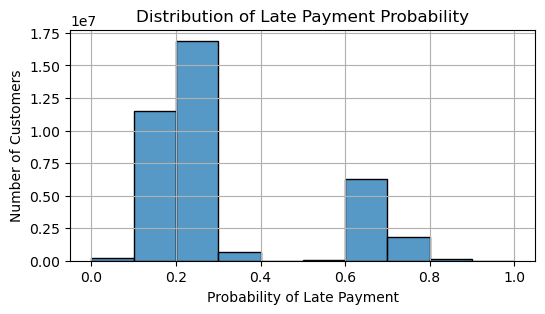

In [596]:
# Histogram of the probability of late payments
plt.figure(figsize=(6, 3))
sns.histplot(customer_aggregation['Probability_of_Late_Payment'], bins=10, kde=False)
plt.title('Distribution of Late Payment Probability')
plt.xlabel('Probability of Late Payment')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()


# Probability Threshold may be decided (e.g. 50%) - Focus can be provided to these customers on Late Payemnts.

# Working on Open_Invoice_data

In [8]:
import pandas as pd

# Load the CSV file
file_path = 'Open_Invoice_data.csv'
data_Open = pd.read_csv(file_path, encoding='cp1252')

data_Open.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88204 entries, 0 to 88203
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AS_OF_DATE            88204 non-null  object 
 1   Customer Type         88204 non-null  object 
 2   Customer_Name         88204 non-null  object 
 3   Customer Account No   88201 non-null  float64
 4   Transaction Number    88195 non-null  object 
 5   Transaction Date      88204 non-null  object 
 6   Payment Term          88204 non-null  object 
 7   Due Date              88204 non-null  object 
 8   Transaction Currency  88204 non-null  object 
 9   Local Amount          88204 non-null  object 
 10  Transaction Class     88204 non-null  object 
 11  AGE                   88204 non-null  int64  
 12  USD Amount            88204 non-null  object 
 13  INV_CREATION_DATE     88204 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 9.4+ MB


In [ ]:
# Convert date columns to datetime format
data_Open['AS_OF_DATE'] = pd.to_datetime(data_Open['AS_OF_DATE'], errors='coerce')
data_Open['Transaction Date'] = pd.to_datetime(data_Open['Transaction Date'], errors='coerce')
data_Open['Due Date'] = pd.to_datetime(data_Open['Due Date'], errors='coerce')
data_Open['INV_CREATION_DATE'] = pd.to_datetime(data_Open['INV_CREATION_DATE'], errors='coerce')

# Convert 'USD Amount' and 'Local Amount' to numerical columns
data_Open['USD Amount'] = pd.to_numeric(data_Open['USD Amount'], errors='coerce')
data_Open['Local Amount'] = pd.to_numeric(data_Open['Local Amount'], errors='coerce')

# Calculate payment term in days from invoice creation date to due date
data_Open['PAYMENT_TERM_DAYS'] = (data_Open['Due Date'] - data_Open['INV_CREATION_DATE']).dt.days

# Filter rows where 'AGE' is negative
filtered_data_Open = data_Open[data_Open['AGE'] < 0]

# Check for rows where 'USD Amount' and 'Local Amount' are null among filtered data
null_usd_count = filtered_data_Open['USD Amount'].isnull().sum()
null_local_count = filtered_data_Open['Local Amount'].isnull().sum()

# Output the counts of null entries
print(f"Number of null USD Amount entries where AGE < 0: {null_usd_count}")
print(f"Number of null Local Amount entries where AGE < 0: {null_local_count}")

In [636]:
print(data_Open.isnull().sum()),print("*"*50),print(filtered_data_Open.isnull().sum())

AS_OF_DATE                  0
Customer Type               0
Customer_Name               0
Customer Account No         3
Transaction Number          9
Transaction Date            0
Payment Term                0
Due Date                    0
Transaction Currency        0
Local Amount            42432
Transaction Class           0
AGE                         0
USD Amount              34628
INV_CREATION_DATE           0
PAYMENT_TERM_DAYS           0
dtype: int64
**************************************************
AS_OF_DATE                  0
Customer Type               0
Customer_Name               0
Customer Account No         0
Transaction Number          0
Transaction Date            0
Payment Term                0
Due Date                    0
Transaction Currency        0
Local Amount            20990
Transaction Class           0
AGE                         0
USD Amount              17789
INV_CREATION_DATE           0
PAYMENT_TERM_DAYS           0
dtype: int64


(None, None, None)

In [637]:
# Replace null values in 'USD Amount' with 0
filtered_data_Open['USD Amount'] = filtered_data_Open['USD Amount'].fillna(0)
# Filter rows where 'USD Amount' is negative
filtered_data_Open = filtered_data_Open[filtered_data_Open['USD Amount'] >= 0]

In [638]:
filtered_data_Open['Invoice_Month'] = filtered_data_Open['INV_CREATION_DATE'].dt.month

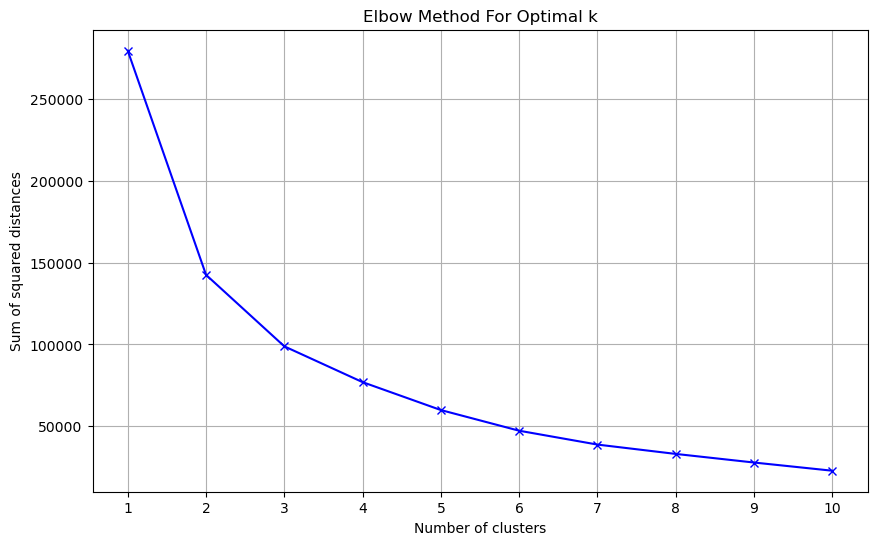

In [639]:
from sklearn.cluster import KMeans
# Compute average and standard deviation of payment time for each customer
customer_stats = filtered_data_Open.groupby('Customer Account No').agg(
    Average_Payment_AGE=('AGE', 'mean'),
    SD_Payment_AGE=('AGE', 'std')
).fillna(0)  # Fill NaN with 0, which can happen if all records for a customer have the same payment time

# Determine the optimal number of clusters using the Elbow Method
# Range of potential clusters to test
K = range(1, 11)  # Testing from 1 to 10 clusters
sum_of_squared_distances = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(customer_stats[['Average_Payment_AGE', 'SD_Payment_AGE']])
    sum_of_squared_distances.append(km.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(K)  # Ensure all cluster tick marks are shown
plt.grid(True)
plt.show()

In [640]:
# After determining the optimal number of clusters from the plot, proceed with that number
optimal_k = int(input("Enter the optimal number of clusters as observed from the Elbow Plot: "))# flexibility to run the codes below with different sets of clusters

Enter the optimal number of clusters as observed from the Elbow Plot:  4


In [641]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_stats['Cluster'] = kmeans.fit_predict(customer_stats[['Average_Payment_AGE', 'SD_Payment_AGE']])

# Merge the cluster labels back to the original data
filtered_data_Open = filtered_data_Open.join(customer_stats['Cluster'], on='Customer Account No')

In [642]:
# Summary statistics for each cluster
cluster_summary = customer_stats.groupby('Cluster').agg(
    Count=('Cluster', 'size'),
    Avg_Payment_Time=('Average_Payment_AGE', 'mean'),
    Std_Dev_Payment_Time=('SD_Payment_AGE', 'mean')
)

print(cluster_summary)

         Count  Avg_Payment_Time  Std_Dev_Payment_Time
Cluster                                               
0          383        -18.620430              3.430686
1           57        -67.329832             22.656989
2          105        -44.899830              1.267108
3          233        -34.445663             17.507051


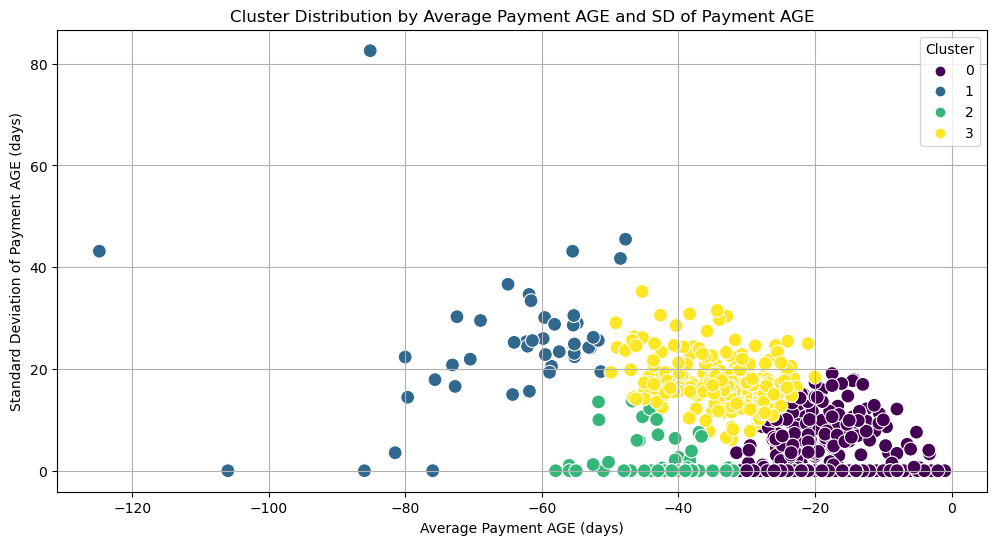

In [643]:
# Visualizing the clusters
# Distribution of Average Payment Time and Standard Deviation by Cluster
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Average_Payment_AGE', y='SD_Payment_AGE', hue='Cluster', data=customer_stats, palette='viridis', s=100)
plt.title('Cluster Distribution by Average Payment AGE and SD of Payment AGE')
plt.xlabel('Average Payment AGE (days)')
plt.ylabel('Standard Deviation of Payment AGE (days)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [644]:
filtered_data_Open.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28075 entries, 2 to 88189
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   AS_OF_DATE            28075 non-null  datetime64[ns]
 1   Customer Type         28075 non-null  object        
 2   Customer_Name         28075 non-null  object        
 3   Customer Account No   28075 non-null  float64       
 4   Transaction Number    28075 non-null  object        
 5   Transaction Date      28075 non-null  datetime64[ns]
 6   Payment Term          28075 non-null  object        
 7   Due Date              28075 non-null  datetime64[ns]
 8   Transaction Currency  28075 non-null  object        
 9   Local Amount          7086 non-null   float64       
 10  Transaction Class     28075 non-null  object        
 11  AGE                   28075 non-null  int64         
 12  USD Amount            28075 non-null  float64       
 13  INV_CREATION_DATE    

In [647]:
X_open_invoice = filtered_data_Open.drop(columns=['AS_OF_DATE','Customer Type','Customer_Name','Customer Account No','Transaction Number','Transaction Date','Payment Term','Due Date','Local Amount','AGE','INV_CREATION_DATE','Cluster'])

In [654]:

# Rename columns for compatibility with the preprocessor/model
X_open_invoice.rename(columns={
    'Transaction Class': 'INVOICE_CLASS',
    'Transaction Currency': 'INVOICE_CURRENCY_CODE'
}, inplace=True)

# Ensure the preprocessing and prediction steps are correctly applied
X_open_invoice_transformed = preprocessor.transform(X_open_invoice)
# Convert the transformed data back to a DataFrame for further manipulation or inspection
cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)
all_features = list(numerical_cols) + list(cat_features)
X_open_invoice_df = pd.DataFrame(X_open_invoice_transformed, columns=all_features)


# Now you can use .info() on this DataFrame
X_open_invoice_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28075 entries, 0 to 28074
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   USD Amount                 28075 non-null  float64
 1   PAYMENT_TERM_DAYS          28075 non-null  float64
 2   Invoice_Month              28075 non-null  float64
 3   INVOICE_CLASS_CM           28075 non-null  float64
 4   INVOICE_CLASS_DM           28075 non-null  float64
 5   INVOICE_CLASS_INV          28075 non-null  float64
 6   INVOICE_CURRENCY_CODE_AED  28075 non-null  float64
 7   INVOICE_CURRENCY_CODE_BHD  28075 non-null  float64
 8   INVOICE_CURRENCY_CODE_EUR  28075 non-null  float64
 9   INVOICE_CURRENCY_CODE_GBP  28075 non-null  float64
 10  INVOICE_CURRENCY_CODE_JOD  28075 non-null  float64
 11  INVOICE_CURRENCY_CODE_KWD  28075 non-null  float64
 12  INVOICE_CURRENCY_CODE_QAR  28075 non-null  float64
 13  INVOICE_CURRENCY_CODE_SAR  28075 non-null  flo

In [658]:
%%time
# List of features as expected by the model based on the training phase
model_features = [
    'USD Amount', 'PAYMENT_TERM_DAYS', 'Invoice_Month',
    'INVOICE_CLASS_INV', 'INVOICE_CURRENCY_CODE_AED', 'INVOICE_CURRENCY_CODE_EUR',
    'INVOICE_CURRENCY_CODE_KWD', 'INVOICE_CURRENCY_CODE_SAR', 'INVOICE_CURRENCY_CODE_USD'
]

# Adding missing features from the model to the test data and initializing them to 0
for feature in model_features:
    if feature not in X_open_invoice_df.columns:
        X_open_invoice_df[feature] = 0.0

# Removing extra features from the test data that are not used by the model
extra_features = set(X_open_invoice_df.columns) - set(model_features)
X_open_invoice_df = X_open_invoice_df.drop(columns=list(extra_features))

# Reordering columns to match the model's expectation
X_open_invoice_df = X_open_invoice_df[model_features]

# Ensure no missing values in any of the numerical features
X_open_invoice_df.fillna(0, inplace=True)

# Making predictions using the best_model
predictions = best_model.predict(X_open_invoice_df)

# Optionally, you can add these predictions back to the DataFrame if needed
X_open_invoice_df['Predictions'] = predictions

# Add the predictions and additional customer information to DataFrame
X_open_invoice_df['Predicted Value'] = predictions
X_open_invoice_df['Customer_Name'] = filtered_data_Open['Customer_Name']
X_open_invoice_df['Customer Account No'] = filtered_data_Open['Customer Account No']

# Revert the column names back to the original names
X_open_invoice_df.rename(columns={
    'INVOICE_CLASS': 'Transaction Class',
    'INVOICE_CURRENCY_CODE': 'Transaction Currency'
}, inplace=True)


CPU times: total: 1.27 s
Wall time: 481 ms


In [667]:
# Define bins and labels with probability ranges
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = [
    'Very Low (0-0.1)', 'Low (0.1-0.2)', 'Moderately Low (0.2-0.3)', 'Moderate (0.3-0.4)',
    'Moderately High (0.4-0.5)', 'High (0.5-0.6)', 'Very High (0.6-0.7)',
    'Higher (0.7-0.8)', 'Highest (0.8-0.9)', 'Absolute (0.9-1.0)'
]

# Bin probabilities and count customers in each bin
customer_aggregation['Probability_Range'] = pd.cut(
    customer_aggregation['Probability_of_Late_Payment'], bins=bins, labels=labels, right=False
)
df_probability_counts = customer_aggregation['Probability_Range'].value_counts().sort_index().reset_index()
df_probability_counts.columns = ['Risk of Default and Range', 'No of Customers']

# Filter for selected ranges and print without index
selected_ranges = ['Very High (0.6-0.7)', 'High (0.5-0.6)', 'Moderately High (0.4-0.5)', 'Moderate (0.3-0.4)', 'Moderately Low (0.2-0.3)', 'Low (0.1-0.2)', 'Very Low (0-0.1)']
df_filtered = df_probability_counts[df_probability_counts['Risk of Default and Range'].isin(selected_ranges)]
print(df_filtered.to_string(index=False))


Risk of Default and Range  No of Customers
         Very Low (0-0.1)               37
            Low (0.1-0.2)               10
 Moderately Low (0.2-0.3)                6
       Moderate (0.3-0.4)                6
Moderately High (0.4-0.5)                4
           High (0.5-0.6)               25
      Very High (0.6-0.7)               14


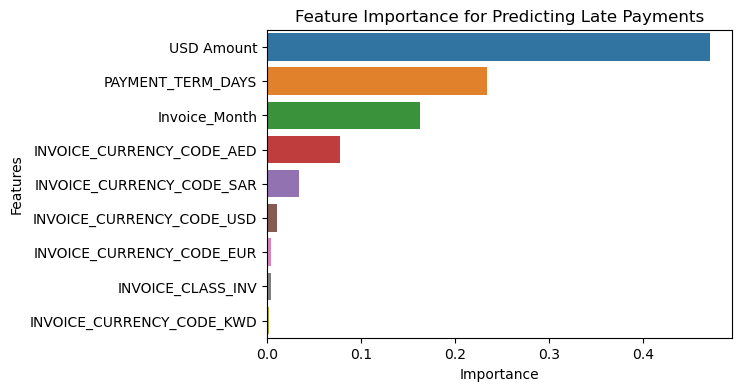

In [669]:
feature_importances = best_model.feature_importances_
features = ['USD Amount', 'PAYMENT_TERM_DAYS', 'Invoice_Month', 'INVOICE_CLASS_INV', 
            'INVOICE_CURRENCY_CODE_AED', 'INVOICE_CURRENCY_CODE_EUR', 'INVOICE_CURRENCY_CODE_KWD', 
            'INVOICE_CURRENCY_CODE_SAR', 'INVOICE_CURRENCY_CODE_USD']

# Create a DataFrame for feature importances
df_features = pd.DataFrame({'Features': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(6,4))
sns.barplot(x='Importance', y='Features', data=df_features)
plt.title('Feature Importance for Predicting Late Payments')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

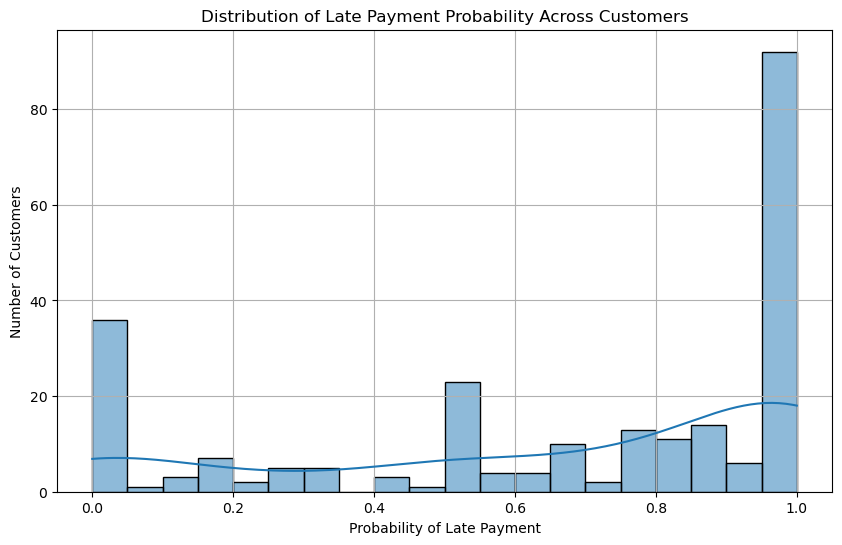

In [670]:
plt.figure(figsize=(10, 6))
sns.histplot(customer_aggregation['Probability_of_Late_Payment'], bins=20, kde=True)
plt.title('Distribution of Late Payment Probability Across Customers')
plt.xlabel('Probability of Late Payment')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()

In [671]:
# Define a risk threshold
risk_threshold = 0.7  # Customers with >70% probability of late payment

# Filter customers above the risk threshold
high_risk_customers = customer_aggregation[customer_aggregation['Probability_of_Late_Payment'] > risk_threshold]
print("Customers Requiring Precautionary Measures:")
print(high_risk_customers[['Customer_Name', 'Probability_of_Late_Payment']].to_string(index=False))


Customers Requiring Precautionary Measures:
Customer_Name  Probability_of_Late_Payment
    ABDU Corp                     1.000000
    ABOU Corp                     1.000000
    ABWA Corp                     1.000000
    AFAQ Corp                     0.964286
    AHLA Corp                     0.790698
    AHME Corp                     1.000000
    AL A Corp                     0.833333
    AL F Corp                     0.870130
    AL J Corp                     0.866667
    AL M Corp                     0.833333
    AL N Corp                     1.000000
    AL P Corp                     1.000000
    AL R Corp                     0.833333
    AL T Corp                     0.956916
    AL Z Corp                     1.000000
    ALBU Corp                     1.000000
    ALRA Corp                     1.000000
    ALRY Corp                     1.000000
    AMUR Corp                     1.000000
    ANSA Corp                     0.750000
    AREE Corp                     0.863014
    ARJW C